In [38]:
import cv2
from utils import scan, showarray, segment_by_color_kmeans
from PIL import Image
import numpy as np
%matplotlib inline

Reading the original Image

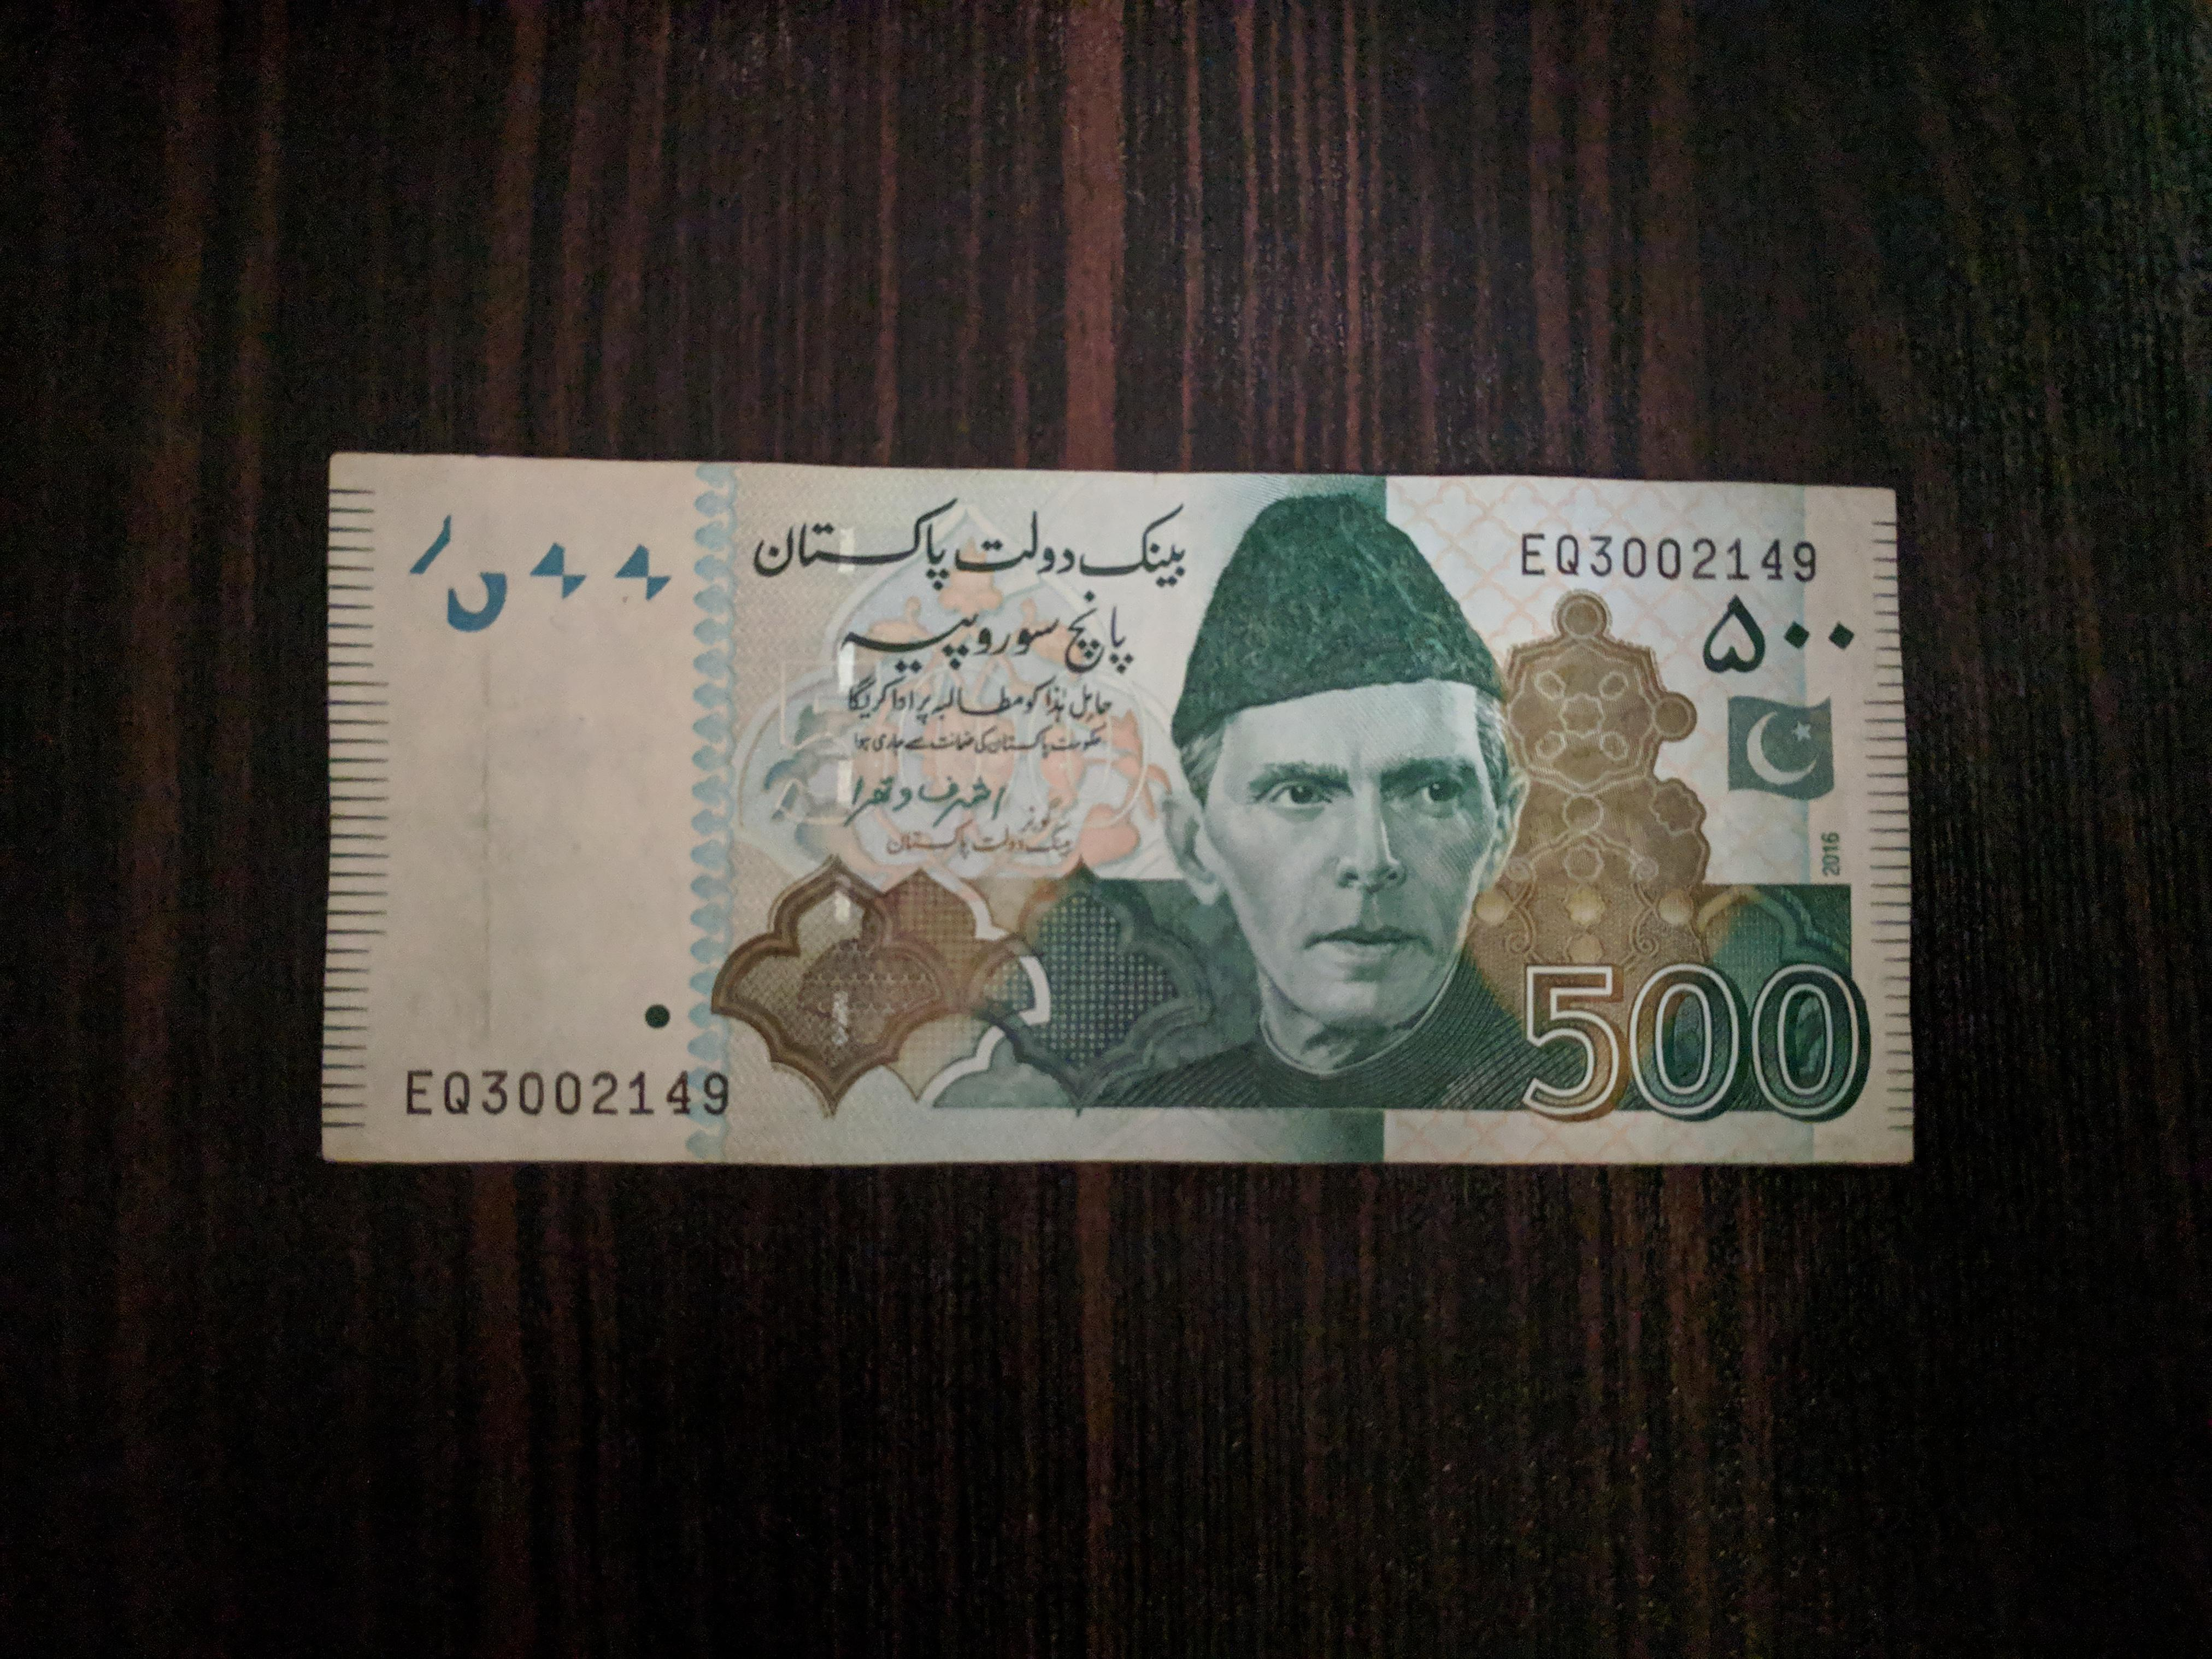

In [39]:
image = cv2.imread("images/500.jpg")
showarray(image)

The bill is segmented out and the background is removed

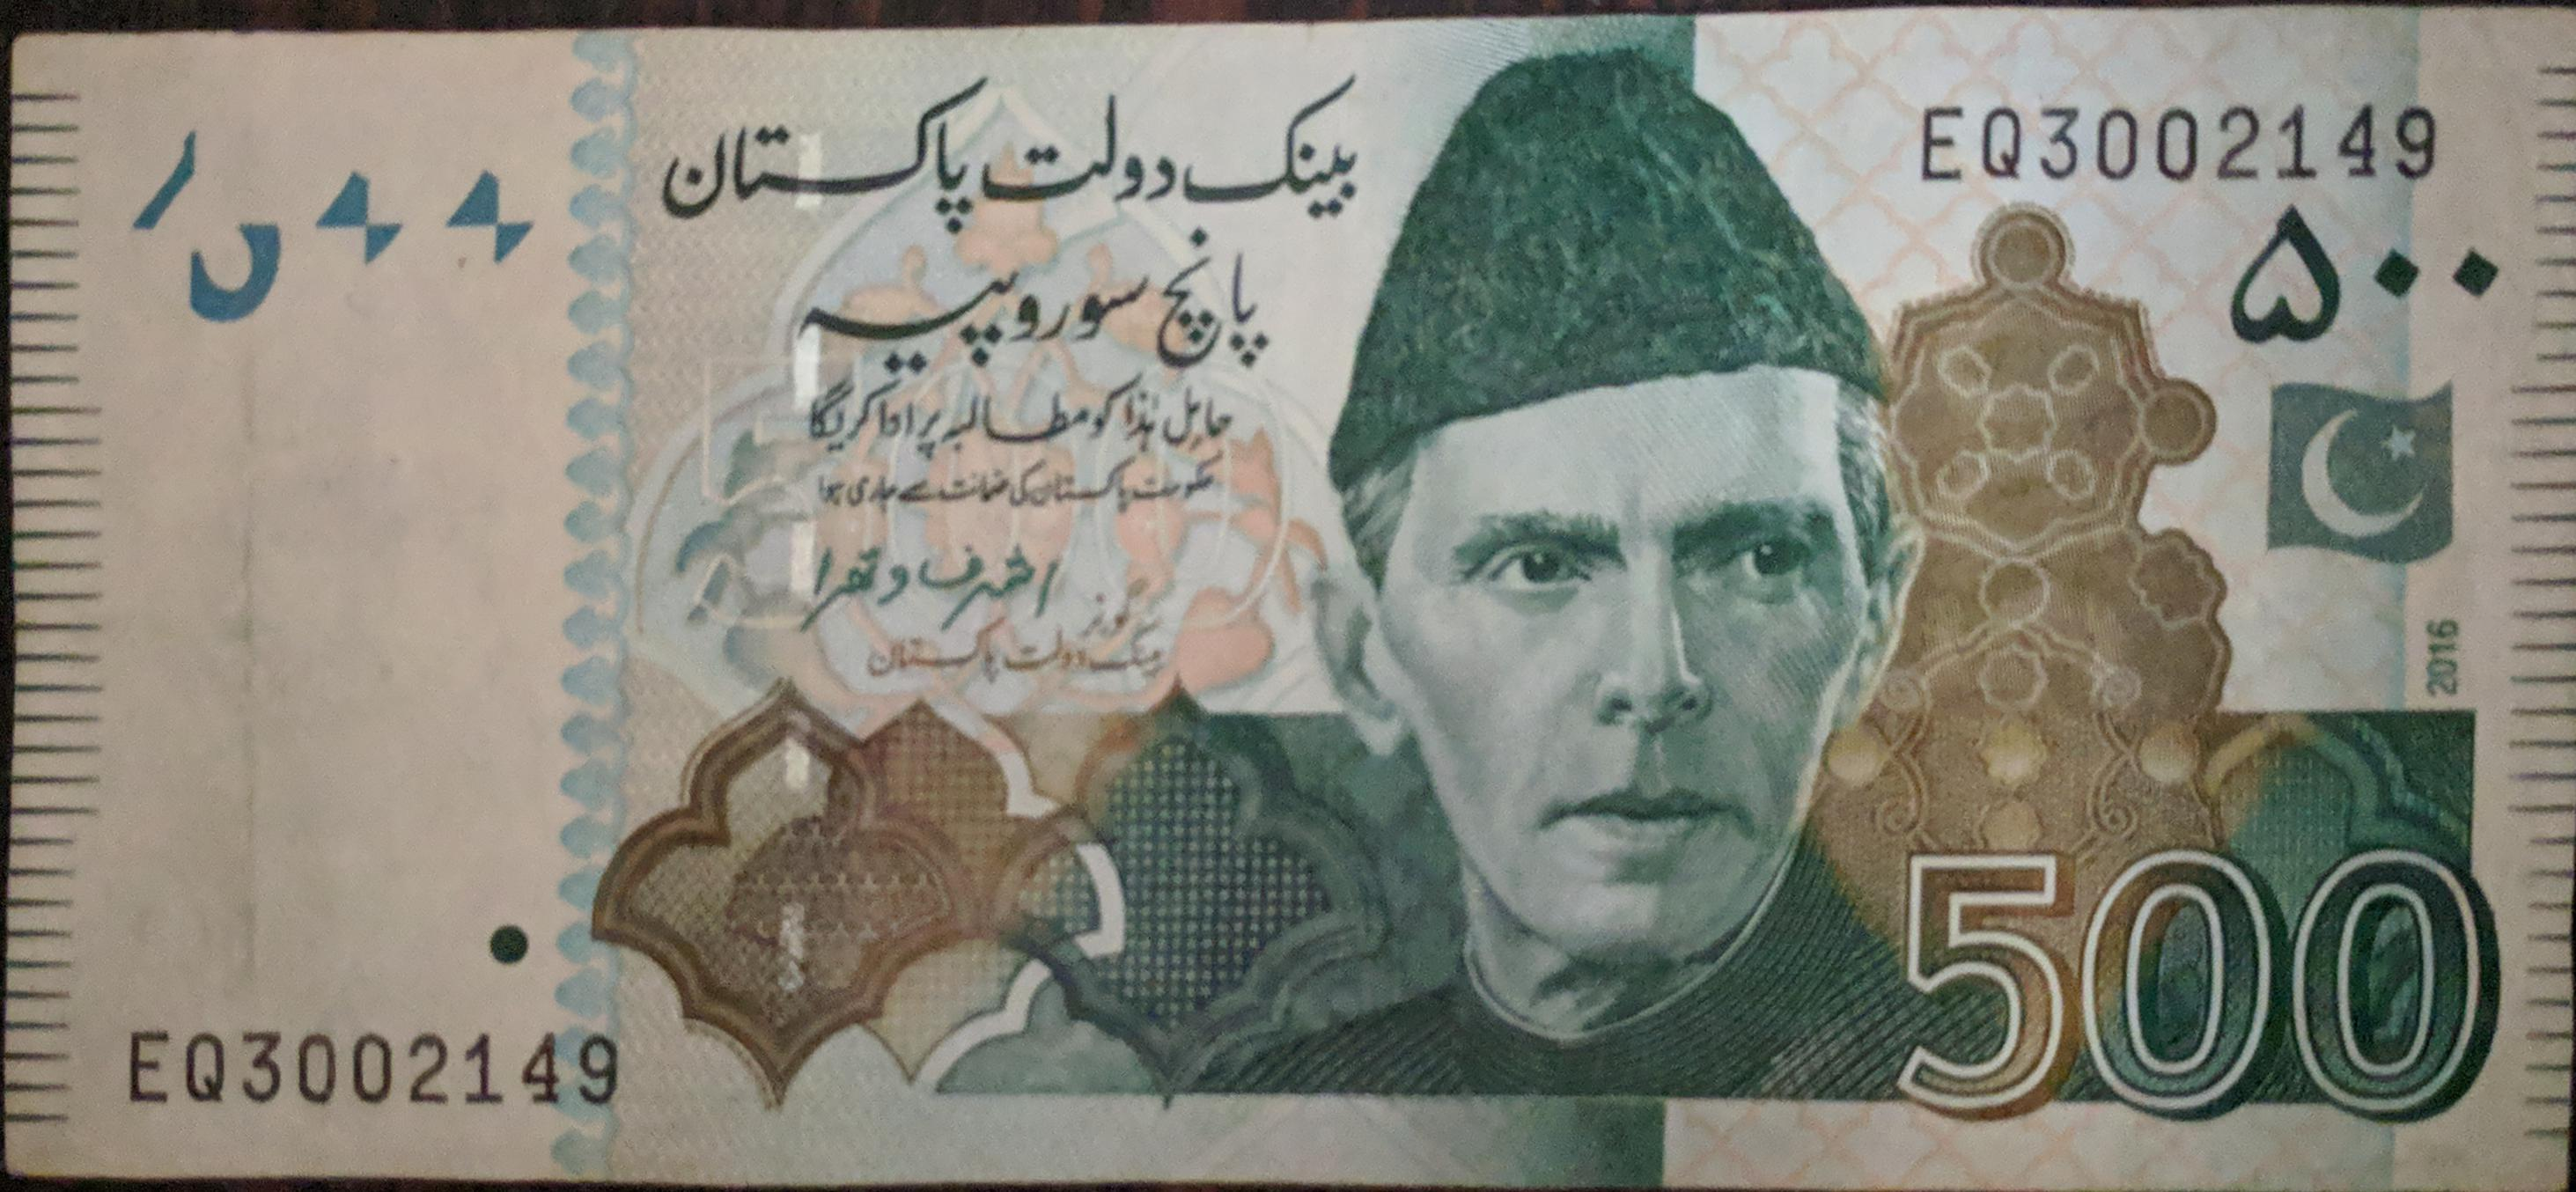

In [40]:
img, warped, blur, edged = scan(image)
showarray(img)

the image is blurred before edge detection

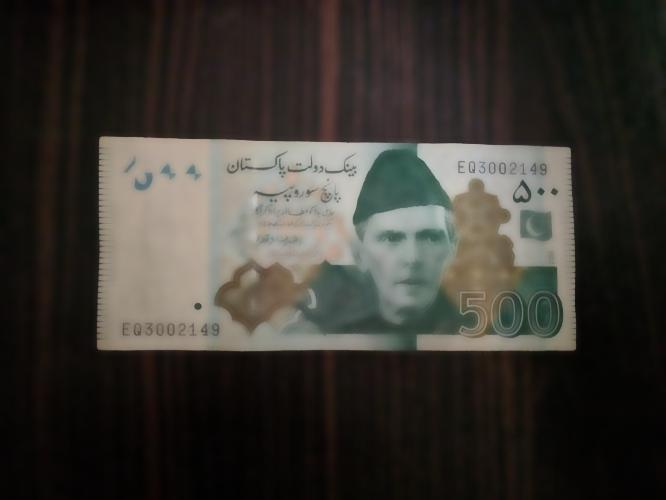

In [41]:
showarray(blur)


The detected edges using Canny edge detector

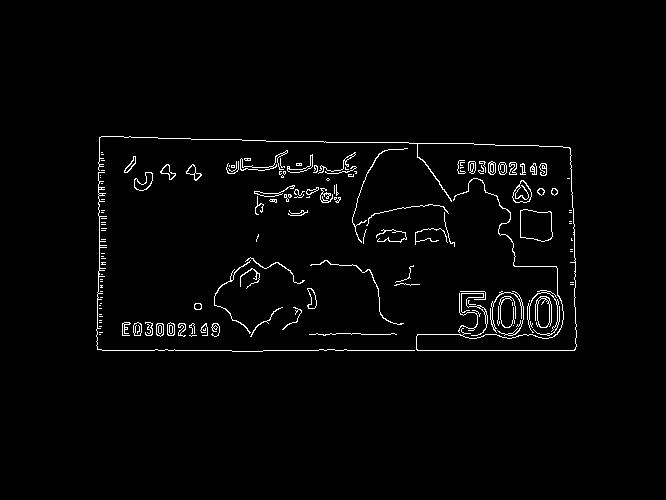

In [42]:
showarray(edged)



The hough lines are drawn and segmented to find the intersection points (corners)

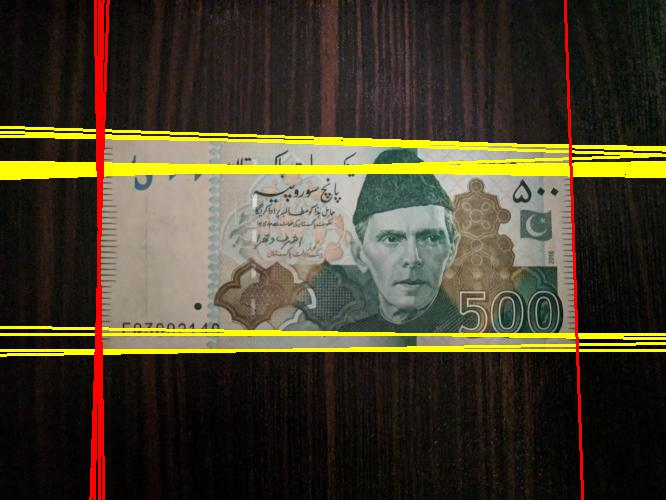

In [43]:
showarray(warped)

# Finding the value of the denomination
The dominant color using K means and the median color is extracted

In [44]:
med, pal, dom = segment_by_color_kmeans(img)

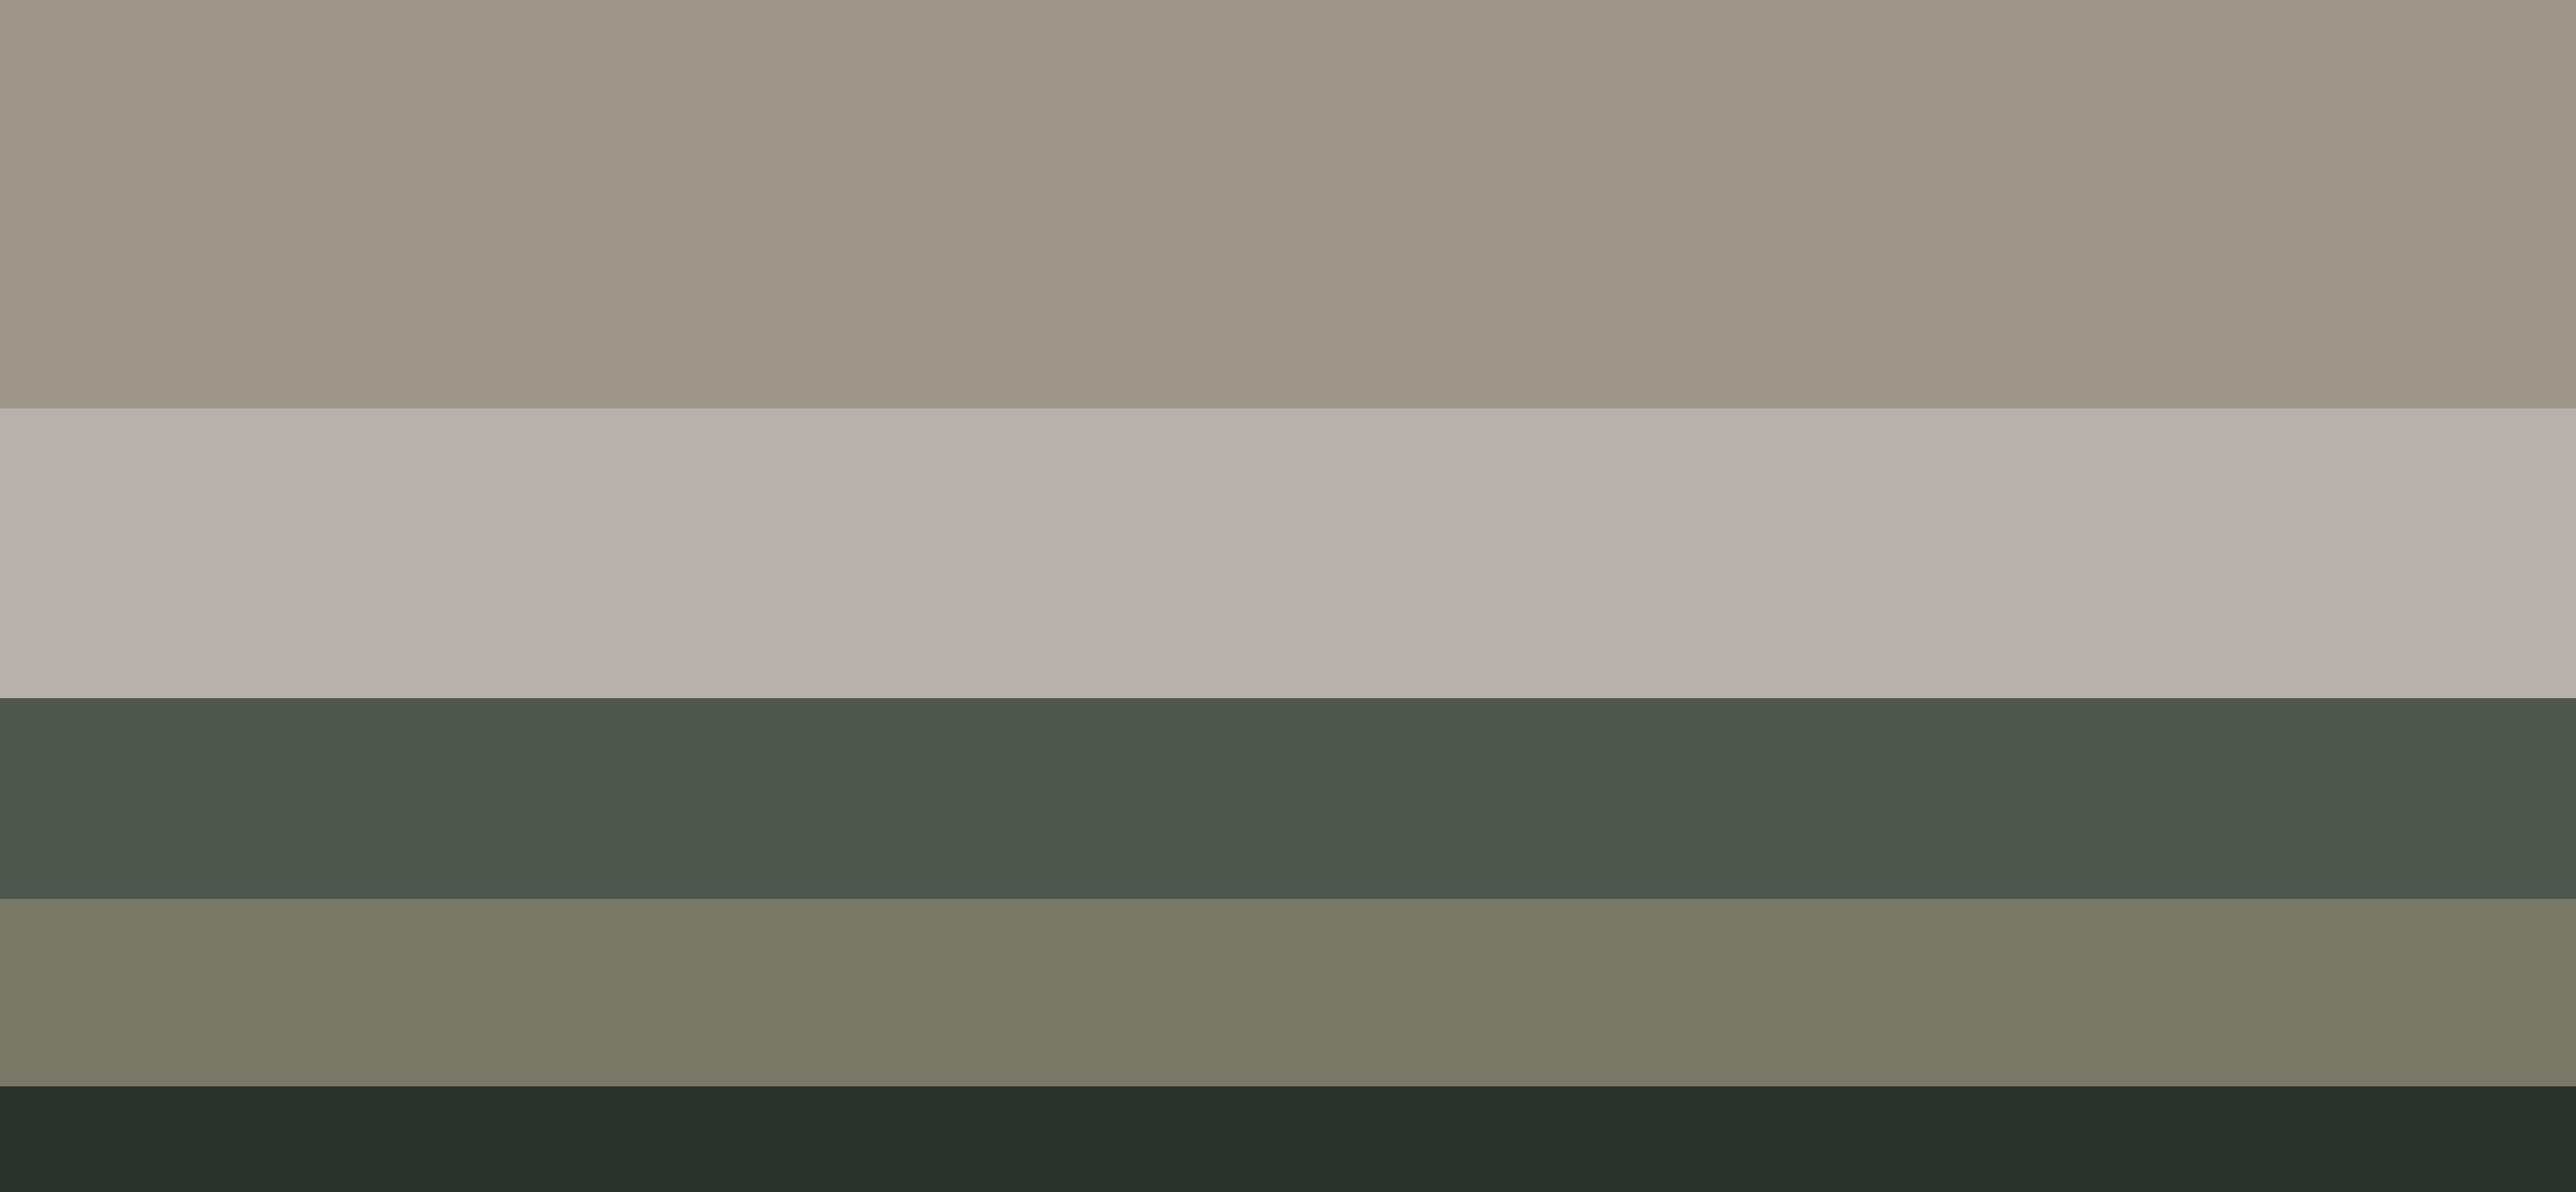

In [45]:
showarray(dom)

The median color of each bill has been stored for comparison

In [46]:
import pickle
with open('codebook.p', 'rb') as fp:
    data = pickle.load(fp)
    
dist = {key: np.linalg.norm(value-med) for (key, value) in data.items()}    

The euclidean distance of each color is found, the label from the color with the least distance is assigned

In [47]:
value = min(dist, key=dist.get)
print(f"Value is {value}Rs")

Value is 500Rs


# Verifying the usability
The Serial Numbers are extracted to verify usability 

1354 2926 3


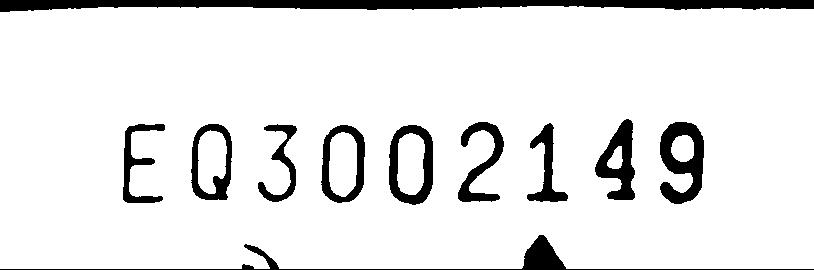

In [48]:
h,w,c = img.shape
print(h,w,c)

num_w=(int)(w/3.2)
num_h=(int)(h/5)

cv2.rectangle(img,(w-num_w,0),(w,num_h),(0,0,255),2)

top_roi = img[0:num_h,(w-num_w+50):w-50,:]
topblur_roi = cv2.bilateralFilter(top_roi,9,150,150)
topgray = cv2.cvtColor(topblur_roi, cv2.COLOR_BGR2GRAY)
topbi = cv2.threshold(topgray,100,255,cv2.THRESH_BINARY)[1]
showarray(topbi)

In [49]:
import pytesseract
from PIL import Image
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files (x86)/Tesseract-OCR/tesseract.exe'
tessdata_dir_config = '--tessdata-dir "C:\\Program Files (x86)\\Tesseract-OCR\\tessdata"'

In [50]:
print(pytesseract.image_to_string(Image.fromarray(topbi), config=tessdata_dir_config))

EQ3002149


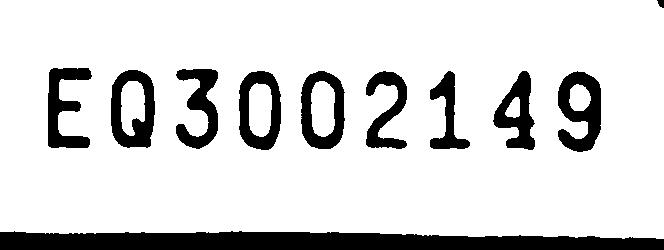

In [51]:
bot_roi = img[h-(num_h-20):h,0+100:num_w-150,:]
botblur_roi = cv2.bilateralFilter(bot_roi,9,150,150)
botgray = cv2.cvtColor(botblur_roi, cv2.COLOR_BGR2GRAY)
botbi = cv2.threshold(botgray,100,255,cv2.THRESH_BINARY)[1]
showarray(botbi)

In [52]:
print(pytesseract.image_to_string(Image.fromarray(botbi), config=tessdata_dir_config))

EQ3002149


# Training the classifiers to identify counterfeit bills

# UV light classifier

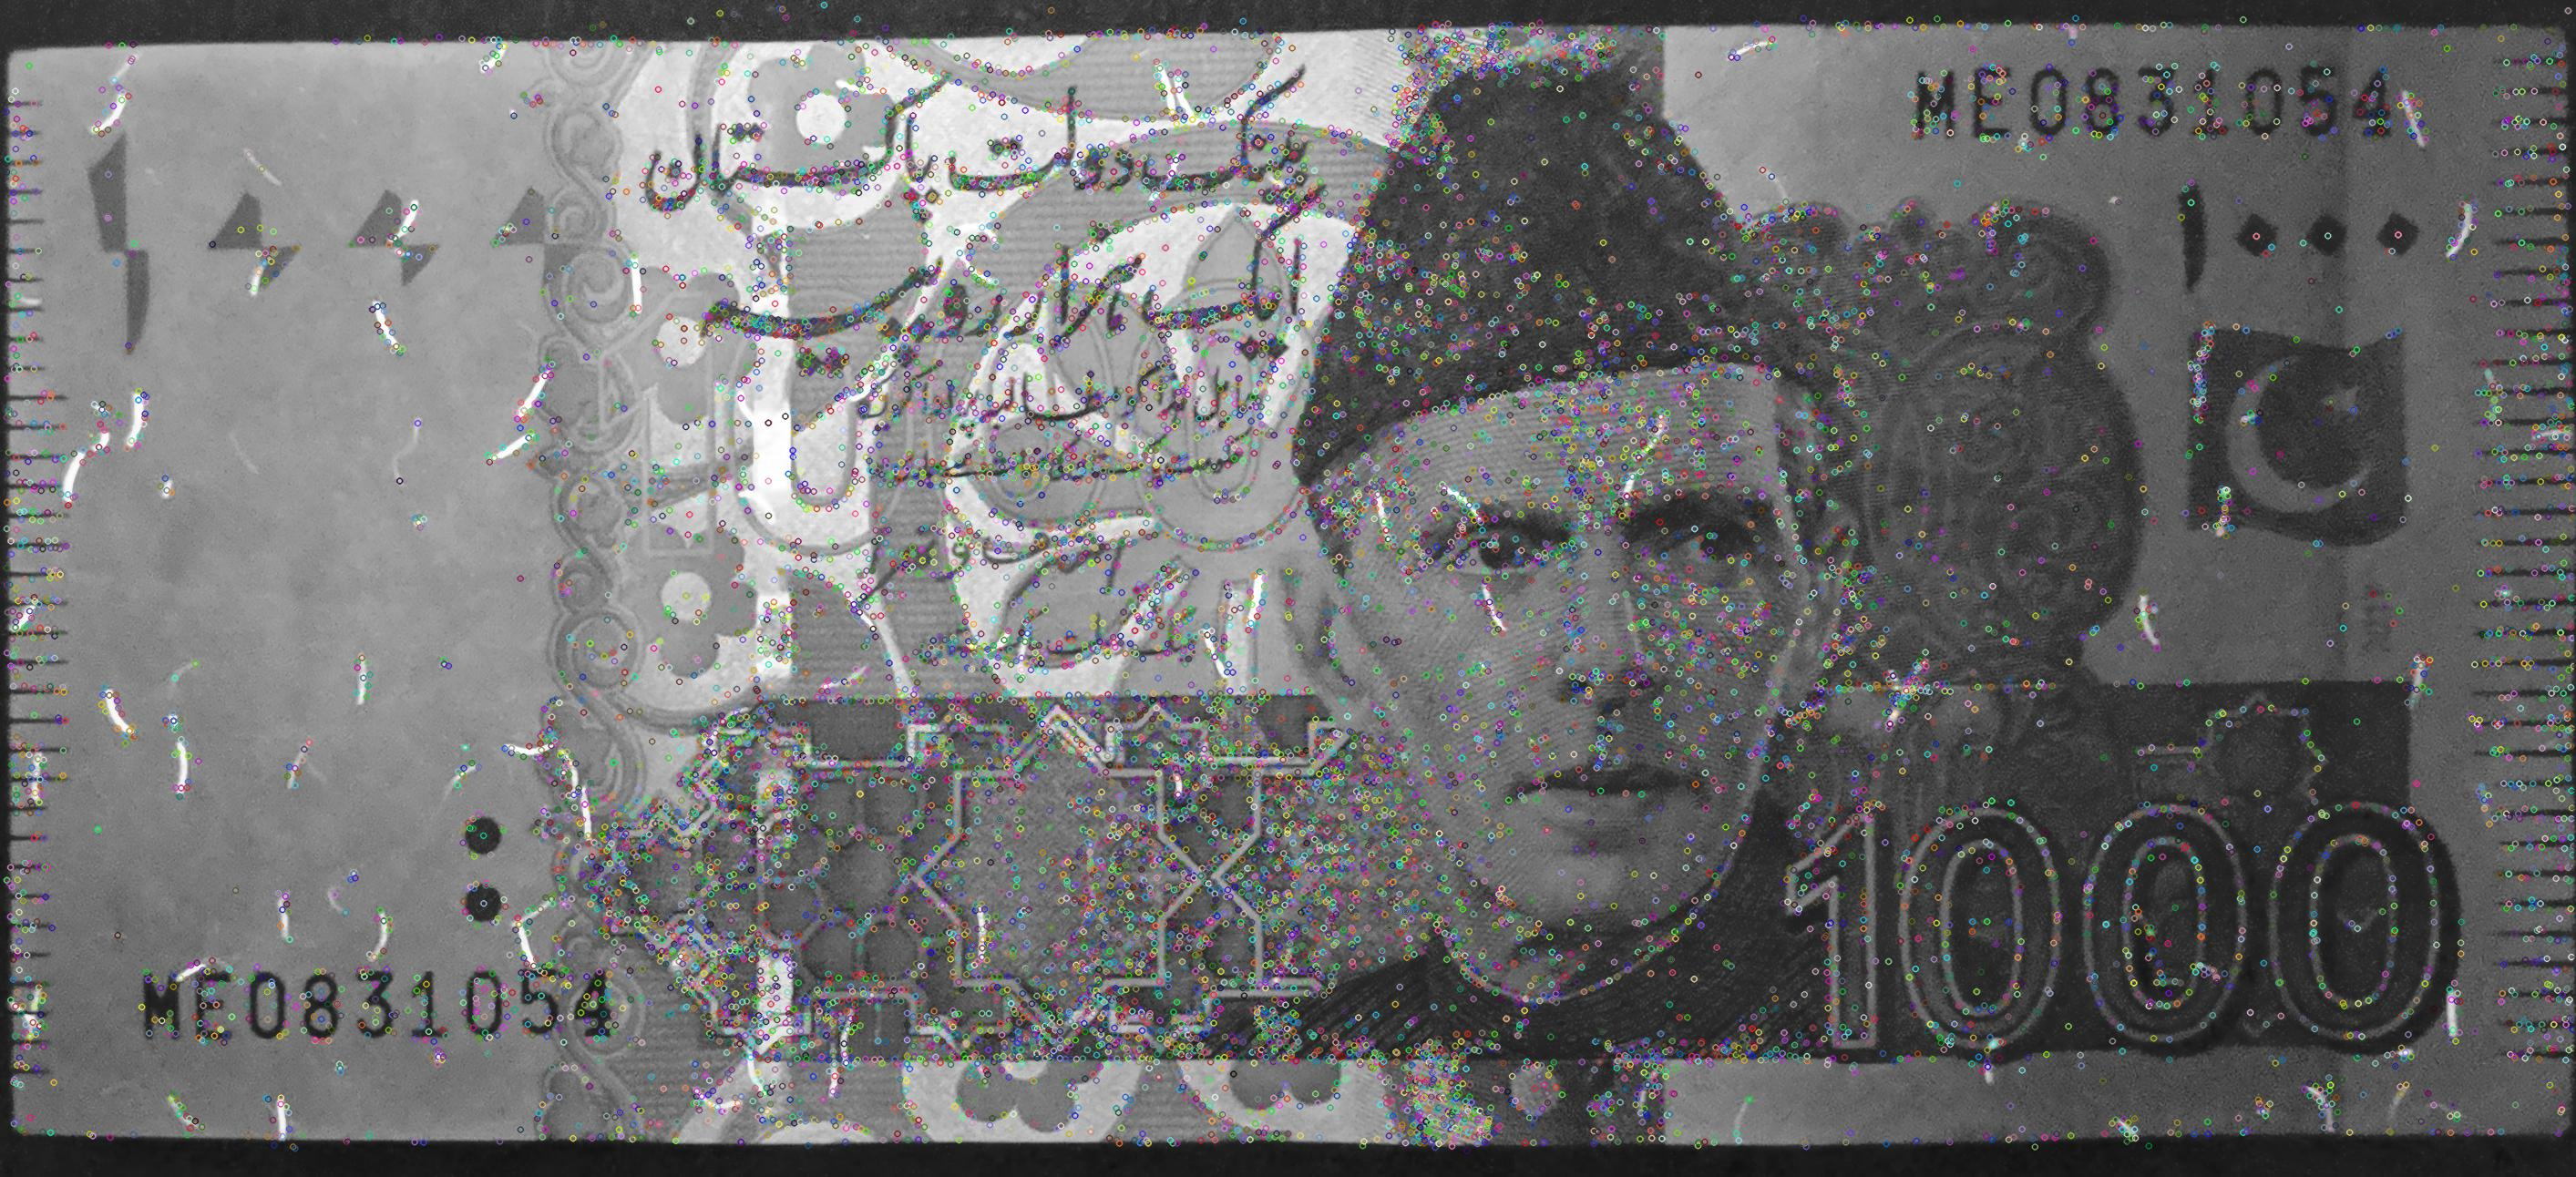

In [53]:
import cv2
import numpy as np

img = cv2.imread('UV_dataset/train_data/genuine/IMG_20190106_170509.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)

img=cv2.drawKeypoints(gray,kp,img)

showarray(img)

In [54]:
import os
from scipy.cluster.vq import kmeans,vq
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.externals import joblib

def imlist(path):
    """
    The function imlist returns all the names of the files in 
    the directory path supplied as argument to the function.
    """
    return [os.path.join(path, f) for f in os.listdir(path)]

In [55]:
train_path = "UV_dataset/train_data"
training_names = os.listdir(train_path)

In [56]:
image_paths = []
image_classes = []
class_id = 0
for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    class_path = imlist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

Creating and appending sift features into a single matrix

In [57]:
sift = cv2.xfeatures2d.SIFT_create()

features = []    
for image_path in image_paths:
    img = cv2.imread(image_path)
    gray= cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    features.append((image_path, des)) 

In [58]:
descriptors = features[0][1]
for image_path, descriptor in features[1:]:
    descriptors = np.vstack((descriptors, descriptor)) 

using kmeans clustering to extract the vocabulary

In [59]:
k = 30
voc, variance = kmeans(descriptors, k) 

Creating the histogram

In [60]:
im_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(features[i][1],voc)
    for w in words:
        im_features[i][w] += 1


Scaling the features

In [61]:
stdSlr = StandardScaler()
im_features = stdSlr.fit_transform(im_features)

Creating and training the SVM classifier

In [62]:
clf = SVC()
clf.fit(im_features, np.array(image_classes))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Storing the trained model, along with the labels and the scaler

In [63]:
joblib.dump((clf, training_names, stdSlr, k, voc), "bof.p", compress=3) 

['bof.p']

# Watermark classifier

In [64]:
train_path = "Notes Watermark\\Notes Watermark\\dataset\\train"
training_names = os.listdir(train_path)

image_paths = []
image_classes = []
class_id = 0
for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    class_path = imlist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

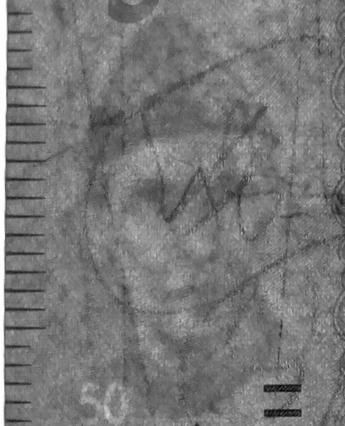

In [65]:
sift = cv2.xfeatures2d.SIFT_create()

features = []    
for image_path in image_paths:
    img = cv2.imread(image_path)
    g= cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    h,w,c = img.shape
    num_w=(int)(w/4)
    num_h=(int)(h/5)
    
    g = g[num_h:h-num_h,0:num_w]
    kp, des = sift.detectAndCompute(g, None)
    features.append((image_path, des))
showarray(g)

descriptors = features[0][1]
for image_path, descriptor in features[1:]:
    descriptors = np.vstack((descriptors, descriptor))

k = 30
voc, variance = kmeans(descriptors, k) 

In [66]:
im_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(features[i][1],voc)
    for w in words:
        im_features[i][w] += 1


In [67]:
stdSlr = StandardScaler()
im_features = stdSlr.fit_transform(im_features)

clf = SVC()
clf.fit(im_features, np.array(image_classes))

joblib.dump((clf, training_names, stdSlr, k, voc), "bof_watermark.p", compress=3) 

['bof_watermark.p']

# Testing

# UV classifier testing

In [68]:
clf, classes_names, stdSlr, k, voc = joblib.load("bof.p")

In [69]:
# Create feature extraction and keypoint detector objects
test_path = "UV_dataset/test"
testing_names = os.listdir(test_path)
image_paths = []
y_label = []

for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imlist(dir)
    for i in class_path:
        y_label.append(testing_name)
    image_paths+=class_path


In [70]:
s = cv2.xfeatures2d.SIFT_create()

# List where all the descriptors are stored
des_list = []

for image_path in image_paths:
    im = cv2.imread(image_path)
    gr= cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
    kp, des = s.detectAndCompute(gr, None)
    des_list.append((image_path, des))   

# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[0:]:
    descriptors = np.vstack((descriptors, descriptor)) 


In [71]:
test_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        test_features[i][w] += 1

In [72]:
# Scale the features
test_features = stdSlr.transform(test_features)

# Perform the predictions
predictions =  [classes_names[i] for i in clf.predict(test_features)]


In [73]:
print("The original labels are:\n",y_label)
print("The predicted labels are:\n",predictions)

The original labels are:
 ['Counterfeit', 'Counterfeit', 'Counterfeit', 'Counterfeit', 'genuine', 'genuine', 'genuine']
The predicted labels are:
 ['Counterfeit', 'Counterfeit', 'Counterfeit', 'Counterfeit', 'genuine', 'genuine', 'genuine']


# watermark classifier testing

In [74]:
clf, classes_names, stdSlr, k, voc = joblib.load("bof_watermark.p")

# Create feature extraction and keypoint detector objects
test_path = "Notes Watermark\\Notes Watermark\\dataset\\test"
testing_names = os.listdir(test_path)
image_paths = []
y_label = []

for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imlist(dir)
    for i in class_path:
        y_label.append(testing_name)
    image_paths+=class_path

s = cv2.xfeatures2d.SIFT_create()

# List where all the descriptors are stored
des_list = []

for image_path in image_paths:
    im = cv2.imread(image_path)
    gr= cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
    h,w = gr.shape
    num_w=(int)(w/4)
    num_h=(int)(h/5)
    
    g = gr[num_h:h-num_h,0:num_w]
    kp, des = s.detectAndCompute(g, None)
    des_list.append((image_path, des))   

# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[0:]:
    descriptors = np.vstack((descriptors, descriptor)) 


test_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        test_features[i][w] += 1

# Scale the features
test_features = stdSlr.transform(test_features)

# Perform the predictions
predictions =  [classes_names[i] for i in clf.predict(test_features)]

print("The original labels are:\n",y_label)
print("The predicted labels are:\n",predictions)

The original labels are:
 ['counterfeit', 'counterfeit', 'counterfeit', 'counterfeit', 'genuine', 'genuine']
The predicted labels are:
 ['counterfeit', 'counterfeit', 'counterfeit', 'counterfeit', 'genuine', 'genuine']
